### Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical as make_class_categorical
import _pickle as pickle
from tqdm import tqdm
import pdb

Using TensorFlow backend.


### Assignment 2 functions

#### Initialize weights

In [47]:
def initialize_weights(d=3072, m=50, K=10, std=0.001):
    """
    Initializes the weight and bias arrays for the 2 layers of the network

    :param d: Dimensionality of the input data
    :param m: Number of nodes in the first layer
    :param K: Number of different classes (K=10 for the CIFAR-10 dataset)
    :param variance (optional): The variance of the normal distribution that will be used for the initialization of the weights

    :return: Weights and bias arrays for the first and second layer of the neural network
    """

    np.random.seed(400)

    W1 = np.random.normal(0, std, size=(m, d))
    b1 = np.zeros(shape=(m, 1))

    W2 = np.random.normal(0, std, size=(K, m))
    b2 = np.zeros(shape=(K, 1))

    return W1, b1, W2, b2

In [46]:
def he_initialization(d=3072, m=50, K=10):
    """
    He initialization on the weight matrices.

    :param d: Dimensionality of input data.
    :param m: Number of nodes in the hidden layer.
    :param K: Number of classes.

    :return: Initialized weight and bias matrices based on He initialization of the weights.
    """
    np.random.seed(400)

    W1 = np.random.randn(m, d) * np.sqrt(2 / float(m))
    W2 = np.random.randn(K, m) * np.sqrt(2 / float(K))

    b1 = np.zeros(shape=(m, 1))
    b2 = np.zeros(shape=(K, 1))

    return W1, b1, W2, b2

#### Load Batch

In [5]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

#### ReLU's

In [6]:
def ReLU(x):
    """
    Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(x, 0)

In [62]:
def Leaky_ReLU(x):
    """
    Leaky Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(0.01*x, x)

#### Softmax

In [7]:
def softmax(X, theta=1.0, axis=None):

    # Softmax over numpy rows and columns, taking care for overflow cases
    # Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    # Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

#### Evaluate Classifier

In [61]:
def EvaluateClassifier(X, W1, b1, W2, b2, with_leaky_relu= False):
    """
    Computes the Softmax output of the 2 layer network, based on input data X and trained weight and bias arrays

    :param X: Input data
    :param W1: Weight array of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight array of the second layer
    :param b2: Bias vector of the second layer

    :return: Softmax output of the trained network
    """

    s1 = np.dot(W1, X) + b1
    if not with_leaky_relu:
        h = ReLU(s1)
    else:
        h = Leaky_ReLU(s1)
    s = np.dot(W2, h) + b2
    p = softmax(s, axis=0)

    return p, h, s1

#### Predict classes

In [9]:
def predictClasses(p):
    """
    Predicts classes based on the softmax output of the network

    :param p: Softmax output of the network
    :return: Predicted classes
    """

    return np.argmax(p, axis=0)

#### Compute Accuracy

In [10]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    """
    Computes the accuracy of the feed-forward 2-layer network

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer

    :return: Accuracy metric of the neural network.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

#### Compute Cost

In [11]:
def ComputeCost(X, Y, W1, W2, b1, b2, regularization_term= 0):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param regularization_term: Amount of regularization applied.

    :return: Cross-entropy loss.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = np.power(W1, 2).sum() + np.power(W2, 2).sum()

    return cross_entropy_loss + regularization_term * weight_sum

#### Compute Gradients

In [14]:
def ComputeGradients(X, Y, W1, b1, W2, b2, p, h, s1, regularization_term= 0):
    """
    Computes gradient descent updates on a batch of data

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param p: Softmax probabilities (predictions) of the network over classes.
    :param h: ReLU activations of the network.
    :param s1: True outout of the first layer of the network.
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network
    """

    # Back-propagate second layer at first

    g = p - Y
    grad_b2 = g.sum(axis=1).reshape(b2.shape)
    grad_W2 = np.dot(g, h.T)

    # Back-propagate the gradient vector g to the first layer
    g = np.dot(g.T, W2)
    ind = 1 * (s1 > 0)
    g = g.T * ind

    grad_b1 = np.sum(g, axis=1).reshape(b1.shape)
    grad_W1 = np.dot(g, X.T)

    grad_W1 /= X.shape[1]
    grad_b1 /= X.shape[1]
    grad_W2 /= X.shape[1]
    grad_b2 /= X.shape[1]

    # Add regularizers
    grad_W1 = grad_W1 + 2 * regularization_term * W1
    grad_W2 = grad_W2 +2 * regularization_term * W2

    return grad_W1, grad_b1, grad_W2, grad_b2

#### Momentum Update

In [16]:
def initialize_momentum(hyperparameter):
    """
    Initializes the corresponding momentum of a hyperparameter matrix or vector

    :param hyperparameter: The hyperparameter
    :return: The corresponding momentum
    """

    return np.zeros(hyperparameter.shape)

In [17]:
def add_momentum(v_t_prev, hyperpatameter, gradient, eta, momentum_term=0.99):
    """
    Add momentum to the update of the hyperparameter at each update step, in order to speed up training

    :param v_t_prev: The momentum update of the previous time step
    :param hyperpatameter: The corresponding hyperparameters
    :param gradient: The value of the gradient update as computed in each time step
    :param eta: The learning rate of the training process
    :param r (optional): The momentum factor, typically 0.9 or 0.99

    :return: The updated hyperparameter based on the momentum update, and the  momentum update itself
    """

    v_t = momentum_term * v_t_prev + eta * gradient

    return hyperpatameter - v_t, v_t



#### Mini-Batch Gradient Descent

In [57]:
def MiniBatchGDwithMomentum(X, Y, X_validation, Y_validation, y_validation, GDparams, W1, b1, W2, b2,
                            regularization_term=0, with_annealing = False, with_leaky_relu= False, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param W1: Weight matrix of the first layer of the network.
    :param b1: Bias vector of the first layer of the network.
    :param W2: Weight matrix of the second layer of the network.
    :param b2: Bias vector of the second layer of the network.
    :param regularization_term: Amount of regularization applied.
    :param with_annealing: Set to true to allow decaying the learning rate by half every 5 epochs.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    v_W1 = initialize_momentum(W1)
    v_b1 = initialize_momentum(b1)
    v_W2 = initialize_momentum(W2)
    v_b2 = initialize_momentum(b2)

    # print('Training set loss before start of training process: '+str(ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)))

    original_training_cost = ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)

    best_W1 = np.copy(W1)
    best_b1 = np.copy(b1)
    best_W2 = np.copy(W2)
    best_b2 = np.copy(b2)

    best_validation_set_accuracy = 0

    for epoch in tqdm(range(epoches)):
        # for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, h, s1 = EvaluateClassifier(X[:, start:end], W1, b1, W2, b2, with_leaky_relu)

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:, start:end], Y[:, start:end], W1, b1, W2, b2, p,
                                                                  h, s1, regularization_term)

            W1, v_W1 = add_momentum(v_W1, W1, grad_W1, eta, momentum_term)
            b1, v_b1 = add_momentum(v_b1, b1, grad_b1, eta, momentum_term)
            W2, v_W2 = add_momentum(v_W2, W2, grad_W2, eta, momentum_term)
            b2, v_b2 = add_momentum(v_b2, b2, grad_b2, eta, momentum_term)

        validation_set_accuracy = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)

        if validation_set_accuracy > best_validation_set_accuracy:
            best_W1 = np.copy(W1)
            best_b1 = np.copy(b1)
            best_W2 = np.copy(W2)
            best_b2 = np.copy(b2)

            best_validation_set_accuracy = validation_set_accuracy

        epoch_cost = ComputeCost(X, Y, W1, W2, b1, b2)
        # print('Training set loss after epoch number '+str(epoch)+' is: '+str(epoch_cost))
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost = ComputeCost(X_validation, Y_validation, W1, W2, b1, b2)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

        # Decay the learning rate
        if with_annealing:
            if epoch > 1 and epoch // 5 == 0:
                eta /= 2.0
        else:
            eta *= 0.95

    # return W1, b1, W2, b2, cost, val_cost
    return best_W1, best_b1, best_W2, best_b2, cost, val_cost

#### Visualizing functions

In [20]:
def visualize_single_cost(loss, display= False, title = None, save_name= None, save_path='../figures/'):
    """
        Visualization and saving the loss of the network.

        :param loss: Loss of the network.
        :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
        :param title: (Optional) Title of the plot.
        :param save_name: (Optional) name of the file to save the plot.
        :param save_path: (Optional) Path of the folder to save the plot in your local computer.

        :return: None

        """

    if title is not None:
        plt.title(title)

    plt.plot(loss)

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name+'.png')

    if display:
        plt.show()

    plt.clf()

In [21]:
def visualize_costs(loss, val_loss, display= False, title = None, save_name= None, save_path='../figures/'):
    """
    Visualization and saving the losses of the network.

    :param loss: Loss of the network.
    :param val_loss: Loss of the network in the validation set.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(loss, 'g', label='Training set ')
    plt.plot(val_loss, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] !='/':
            save_path+='/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

### ASSIGNMENT 2 EXERCISES

####  Exercise 1: Read in the data & initialize the parameters ofthe network

In [22]:
def exercise_1():
    """
    DD2424 Assignemnt 2, Exercise 1: Read the data & initialize the parameters of the network

    :return: Data of the tarining and testing process and initialized parameters for the weights and bias of the network
    """
    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training_1)
    X_training_1 -= mean
    X_training_2 -= mean
    X_test -= mean

    training_data = [X_training_1, Y_training_1, y_training_1]
    validation_data = [X_training_2, Y_training_2, y_training_2]
    test_data = [X_test, y_test]

    W1, b1, W2, b2 = initialize_weights(d=X_training_1.shape[0], m=50, K=Y_training_1.shape[0])

    return training_data, validation_data, test_data, W1, b1, W2, b2

In [87]:
training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
X_training, Y_training, y_training = training_data
X_validation, Y_validation, y_validation = validation_data
X_test, y_test = test_data

#### Exercise 2: Compute the gradients for the network parameters

In [23]:
p, h, s1 = EvaluateClassifier(X_training_1[:,0:2], W1, b1, W2, b2)
grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X_training[:,0:2], Y_training[:,0:2], W1, b1, W2, b2, p, h, s1)

Test no.1: Compare with numerically computed gradients

In [24]:
grad_W1_num = np.load('grad_W1_num.npy')
grad_b1_num = np.load('grad_b1_num.npy')
grad_W2_num = np.load('grad_W2_num.npy')
grad_b2_num = np.load('grad_b2_num.npy')

In [25]:
check_similarity(grad_W1, grad_b1, grad_W2, grad_b2, grad_W1_num, grad_b1_num, grad_W2_num, grad_b2_num)

Success!!
Average error on weights of first layer=  7.52283628908819e-09
Average error on bias of first layer= 4.602426280088195e-09
Average error on weights of second layer=  3.0747216543846533e-10
Average error on bias of second layer=  1.193638211533644e-11


Test no.2: Overfit on a small subset of training data

100%|██████████| 200/200 [00:09<00:00, 21.68it/s]


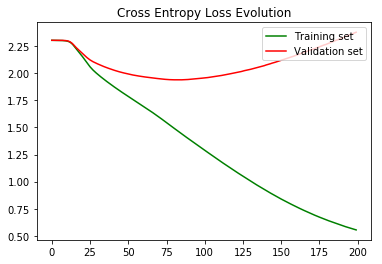

In [26]:
W1, b1, W2, b2 = initialize_weights(d=X_training_1.shape[0], m=50, K=Y_training_1.shape[0])
GD_params = [100, 0.05, 200]

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGD(   X_training[:, :1000],
                                                                        Y_training[:, :1000],
                                                                        X_validation[:, :1000],
                                                                        Y_validation[:, :1000],
                                                                        y_validation,
                                                                        GD_params,
                                                                        W1, b1, W2, b2)

visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution')

We observe overfitting in the training data, as the loss on the training set gets pretty small values, while the loss on the validation set starts increasing after a few number of epochs. 

#### Exercise 3: Add momentum to your update step

In [34]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :2000],
                                                                                    Y_training[:, :2000],
                                                                                    X_validation[:, :2000],
                                                                                    Y_validation[:, :2000],
                                                                                    y_validation,
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.99)

100%|██████████| 200/200 [00:20<00:00,  9.59it/s]


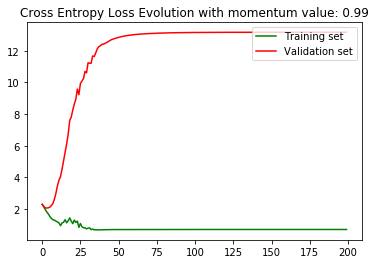

<Figure size 432x288 with 0 Axes>

In [37]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.99')

In [44]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :2000],
                                                                                    Y_training[:, :2000],
                                                                                    X_validation[:, :2000],
                                                                                    Y_validation[:, :2000],
                                                                                    [], [],
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.9)


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


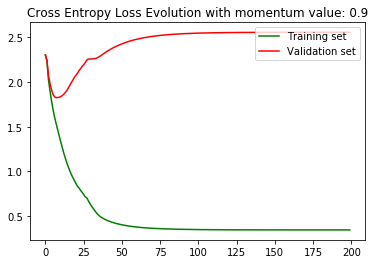

<Figure size 432x288 with 0 Axes>

In [45]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.9')

In [46]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :500],
                                                                                    Y_training[:, :500],
                                                                                    X_validation[:, :500],
                                                                                    Y_validation[:, :500],
                                                                                    [], [],
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.)


100%|██████████| 200/200 [00:05<00:00, 36.37it/s]

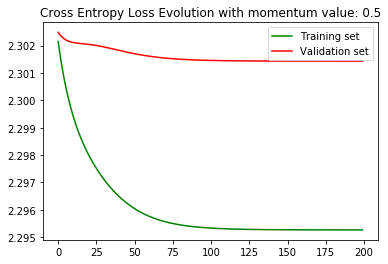

<Figure size 432x288 with 0 Axes>

In [47]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.5', save_name='3_momentum_0-5', save_path='../figures')

#### Exercise 4: Training your network

#### Random search

In [88]:
def random_search():
    """
    Random search to estimate the rough bounds for the values to eta to look for later in the coarse search.

    :return:
    """

    training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
    X_training, Y_training, y_training = training_data
    X_validation, Y_validation, y_validation = validation_data

    for eta in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:

        print('-----------------------')
        print('eta: ', eta)

        GD_params = [100, eta, 5]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=0.000001,
                                                                                         momentum_term=0.9)

        W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

#             visualize_single_cost(training_set_loss, display=False, title='Training set loss evolution for eta: '+str(eta), save_name='Eta_random_'+str(eta).replace('.', '-'))

    for eta in np.arange(0.2, 0.5, 0.05):

        print('-----------------------')
        print('eta: ', eta)

        GD_params = [100, eta, 5]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=0.000001,
                                                                                         momentum_term=0.9)

        W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

#             visualize_single_cost(training_set_loss, display=False, title='Training set loss evolution for eta: '+str(eta), save_name='Eta_random_'+str(eta).replace('.', '-'))

In [32]:
random_search()

-----------------------
eta:  1e-05
Training set loss after epoch number 0 is: 2.3025848506920643
Training set loss after epoch number 1 is: 2.302583841443368
Training set loss after epoch number 2 is: 2.3025828840707727
Training set loss after epoch number 3 is: 2.3025819761862096
Training set loss after epoch number 4 is: 2.3025811148946467
-----------------------
eta:  5e-05
Training set loss after epoch number 0 is: 2.302581166802597
Training set loss after epoch number 1 is: 2.3025761599923698
Training set loss after epoch number 2 is: 2.3025714319240826
Training set loss after epoch number 3 is: 2.302566964345669
Training set loss after epoch number 4 is: 2.3025627410959992
-----------------------
eta:  0.0001
Training set loss after epoch number 0 is: 2.30257658291642
Training set loss after epoch number 1 is: 2.302566649200436
Training set loss after epoch number 2 is: 2.3025573099186
Training set loss after epoch number 3 is: 2.302548512635035
Training set loss after epoch num

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Training set loss after epoch number 0 is: inf
-----------------------
eta:  0.44999999999999996
Training set loss after epoch number 0 is: inf


#### Coarse search

In [89]:
def coarse_search(e_min= np.log(0.01), e_max=np.log(0.15)):
    """
    Coarse search, optimal value for the learning rate may be found between 0.01 and 0.15

    :return: Best pair of eta and lambda based on validation set accuracy performance
    """

    training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
    X_training, Y_training, y_training = training_data
    X_validation, Y_validation, y_validation = validation_data

    accuracies = []
    etas = []
    lambdas = []

    for regularization_term in [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1]:

        for _ in range(12):
            np.random.seed()
            eta_term = np.random.rand(1, 1).flatten()[0]
            e = e_min + (e_max - e_min) * eta_term
            eta = np.exp(e)
            etas.append(eta)

            lambdas.append(regularization_term)

            GD_params = [100, eta, 10]

            W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                             Y_training,
                                                                                             X_validation,
                                                                                             Y_validation,
                                                                                             GD_params,
                                                                                             W1, b1, W2, b2,
                                                                                             regularization_term=regularization_term)
            print('---------------------------------')
            print('Learning rate: '+str(eta)+', amount of regularization term: '+str(regularization_term))
            accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
            accuracies.append(accuracy_on_validation_set)
            print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

            W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _ , _ in sort_them_all]
    best_etas = [y for _, y , _ in sort_them_all]
    best_lambdas = [z for _, _ , z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])

    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])

    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

In [39]:
coarse_search()

---------------------------------
Learning rate: 0.01682656011091022, amount of regularization term: 0
Accuracy performance on the validation set:  42.83
---------------------------------
Learning rate: 0.08147359655297683, amount of regularization term: 0
Accuracy performance on the validation set:  39.43
---------------------------------
Learning rate: 0.0475448802275006, amount of regularization term: 0
Accuracy performance on the validation set:  41.67
---------------------------------
Learning rate: 0.043287479050267516, amount of regularization term: 0
Accuracy performance on the validation set:  42.23
---------------------------------
Learning rate: 0.038164956302654054, amount of regularization term: 0
Accuracy performance on the validation set:  42.99
---------------------------------
Learning rate: 0.04900996226997768, amount of regularization term: 0
Accuracy performance on the validation set:  41.29
---------------------------------
Learning rate: 0.09907513432084375, amoun

---------------------------------
Learning rate: 0.04521203024064449, amount of regularization term: 0.001
Accuracy performance on the validation set:  42.36
---------------------------------
Learning rate: 0.05676789861851565, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.22
---------------------------------
Learning rate: 0.018800130793788727, amount of regularization term: 0.001
Accuracy performance on the validation set:  43.22
---------------------------------
Learning rate: 0.03081995705702969, amount of regularization term: 0.001
Accuracy performance on the validation set:  43.77
---------------------------------
Learning rate: 0.01843306331980966, amount of regularization term: 0.001
Accuracy performance on the validation set:  43.12
---------------------------------
Learning rate: 0.012499263976140852, amount of regularization term: 0.001
Accuracy performance on the validation set:  42.22
---------------------------------
Learning rate: 0

#### Fine search

In [60]:
def fine_search():
    """
    Fine search, where we examine the most interesting pairings that were observed during the coarse search.

    :return: accuracies, etas and lambdas of the search
    """

    training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
    X_training, Y_training, y_training = training_data
    X_validation, Y_validation, y_validation = validation_data

    accuracies = []
    etas = []
    lambdas = []

    # For a regularization amount as small as 1e-6, the closest to a 44% validation set
    # accuracy performance was spotted for values of eta ~[0.18, 0.28]
    regularization_term = 1e-6

    W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    for _ in range(10):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e_min = np.log(0.017)
        e_max = np.log(0.019)
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)
        
    W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    for _ in range(10):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e_min = np.log(0.027)
        e_max = np.log(0.029)
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)
        
    # For a regularization amount as small as 1e-5, the closest to a 44% validation set
    # accuracy performance was spotted for values of eta ~[0.22, 0.25]
    regularization_term = 1e-5
    
    W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    for _ in range(20):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e_min = np.log(0.022)
        e_max = np.log(0.027)
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    # For a regularization amount as high as 1e-4, the closest to a 44% validation set
    # accuracy performance was spotted for values of eta ~0.18
    regularization_term = 1e-4
    
    W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    for _ in range(10):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e_min = np.log(0.017)
        e_max = np.log(0.019)
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)
        
    # For a regularization amount as high as 1e-3, the closest to a 44% validation set
    # accuracy performance was spotted for values of eta ~0.28 and eta ~0.3
    regularization_term = 1e-3
    
    W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    for _ in range(20):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e_min = np.log(0.028)
        e_max = np.log(0.032)
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)
        
    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _, _ in sort_them_all]
    best_etas = [y for _, y, _ in sort_them_all]
    best_lambdas = [z for _, _, z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])
    
    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])
    
    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

First run of fine search, with stable weight initialization of np.random.seed(400)

In [61]:
fine_search()

---------------------------------
Learning rate: 0.018551777558089223, amount of regularization term: 1e-06
Accuracy performance on the validation set:  43.11
---------------------------------
Learning rate: 0.018394727031491028, amount of regularization term: 1e-06
Accuracy performance on the validation set:  43.91
---------------------------------
Learning rate: 0.018794276687985924, amount of regularization term: 1e-06
Accuracy performance on the validation set:  42.25
---------------------------------
Learning rate: 0.018241269856306787, amount of regularization term: 1e-06
Accuracy performance on the validation set:  41.24
---------------------------------
Learning rate: 0.018524400049430092, amount of regularization term: 1e-06
Accuracy performance on the validation set:  39.84
---------------------------------
Learning rate: 0.018965984141744892, amount of regularization term: 1e-06
Accuracy performance on the validation set:  38.28
---------------------------------
Learning rat

---------------------------------
Learning rate: 0.03158470815148951, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.79
---------------------------------
Learning rate: 0.028971755173387584, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.61
---------------------------------
Learning rate: 0.029276101740644846, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.32
---------------------------------
Learning rate: 0.030082938532698444, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.35
---------------------------------
Learning rate: 0.029764805685603024, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.01
---------------------------------
Learning rate: 0.029477122315135385, amount of regularization term: 0.001
Accuracy performance on the validation set:  39.67
---------------------------------
Learning rate

Second run of fine search

In [90]:
fine_search()

---------------------------------
Learning rate: 0.017735018087604103, amount of regularization term: 1e-06
Accuracy performance on the validation set:  42.97
---------------------------------
Learning rate: 0.01746419667496226, amount of regularization term: 1e-06
Accuracy performance on the validation set:  43.42
---------------------------------
Learning rate: 0.018093247549295238, amount of regularization term: 1e-06
Accuracy performance on the validation set:  41.48
---------------------------------
Learning rate: 0.018926477020422043, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.29
---------------------------------
Learning rate: 0.018826625600027246, amount of regularization term: 1e-06
Accuracy performance on the validation set:  38.48
---------------------------------
Learning rate: 0.018152155213339433, amount of regularization term: 1e-06
Accuracy performance on the validation set:  39.51
---------------------------------
Learning rate

---------------------------------
Learning rate: 0.030542572662875224, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.44
---------------------------------
Learning rate: 0.028178856969316702, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.38
---------------------------------
Learning rate: 0.031811813587325564, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.56
---------------------------------
Learning rate: 0.02832450608842571, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.64
---------------------------------
Learning rate: 0.02994829441224851, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.01
---------------------------------
Learning rate: 0.031428034046821915, amount of regularization term: 0.001
Accuracy performance on the validation set:  39.92
---------------------------------
Learning rate:

([42.97,
  43.42,
  41.48,
  40.29,
  38.48,
  39.51,
  38.19,
  37.65,
  37.88,
  39.03,
  42.87,
  41.32,
  39.58,
  38.95,
  38.03,
  38.55,
  38.28,
  38.53,
  37.95,
  37.9,
  43.73,
  41.75,
  40.07,
  39.79,
  39.22,
  39.16,
  37.67,
  37.83,
  38.25,
  37.55,
  39.25,
  39.57,
  39.44,
  39.68,
  38.69,
  38.79,
  38.72,
  37.81,
  39.55,
  39.74,
  43.13,
  44.16,
  42.58,
  41.09,
  40.02,
  39.29,
  39.37,
  39.14,
  39.39,
  38.43,
  43.89,
  42.48,
  41.44,
  41.38,
  40.56,
  40.64,
  41.01,
  39.92,
  39.63,
  40.13,
  40.03,
  40.42,
  40.49,
  39.88,
  40.23,
  39.95,
  39.47,
  38.0,
  39.21,
  38.4],
 [0.017735018087604103,
  0.01746419667496226,
  0.018093247549295238,
  0.018926477020422043,
  0.018826625600027246,
  0.018152155213339433,
  0.018836422206563137,
  0.017318336044510982,
  0.01885412675376466,
  0.018946688167993896,
  0.028960908730851248,
  0.0287033408950022,
  0.02841414426365495,
  0.027022855138298597,
  0.028156600897847682,
  0.0284370426285

#### Final search

In [91]:
def final_search(e_min=np.log(0.017), e_max=np.log(0.019)):
    """
    Final search, optimal value for the learning rate may be found between 0.017 and 0.019

    :return: None
    """

    training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
    X_training, Y_training, y_training = training_data
    X_validation, Y_validation, y_validation = validation_data

    accuracies = []
    etas = []
    lambdas = []

    regularization_term = 0.0001

    for _ in range(40):
        np.random.seed()
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                         Y_training,
                                                                                         X_validation,
                                                                                         Y_validation,
                                                                                         y_validation,
                                                                                         GD_params,
                                                                                         W1, b1, W2, b2,
                                                                                         regularization_term=regularization_term)
        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

        W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _, _ in sort_them_all]
    best_etas = [y for _, y, _ in sort_them_all]
    best_lambdas = [z for _, _, z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])

    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])

    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

In [92]:
final_search()

---------------------------------
Learning rate: 0.01807778788365891, amount of regularization term: 0.0001
Accuracy performance on the validation set:  44.03
---------------------------------
Learning rate: 0.01841866665259337, amount of regularization term: 0.0001
Accuracy performance on the validation set:  42.92
---------------------------------
Learning rate: 0.018870547435632684, amount of regularization term: 0.0001
Accuracy performance on the validation set:  43.22
---------------------------------
Learning rate: 0.01739688358362078, amount of regularization term: 0.0001
Accuracy performance on the validation set:  43.21
---------------------------------
Learning rate: 0.018349819029981264, amount of regularization term: 0.0001
Accuracy performance on the validation set:  43.66
---------------------------------
Learning rate: 0.018614612584802317, amount of regularization term: 0.0001
Accuracy performance on the validation set:  43.15
---------------------------------
Learning 

#### For your best found hyperparameter settings, train the network on all the training data (all the batch data), except for 1000 examples in a valida- tion set, for ∼30 epochs. Plot the training and validation cost after each epoch of training and then report the learnt network’s performance on the test data.


In [25]:
def create_sets():

    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_training_3, Y_training_3, y_training_3 = LoadBatch('../../cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch('../../cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch('../../cifar-10-batches-py/data_batch_5')

    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))

    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))

    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)

    y_training = y_training_1 + y_training_3 + y_training_4 + y_training_5 + y_training_2[:9000]

    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]

    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training)
    X_training -= mean
    X_validation -= mean
    X_test -= mean

    return [X_training, Y_training, y_training], [X_validation, Y_validation, y_validation], [X_test, y_test]


In [26]:
training, validation, test = create_sets()

X_training, Y_training, y_training = training
X_validation, Y_validation, y_validation = validation
X_test, y_test = test

Experiment no.1: Eta = 0.018920249916784752, lambda = 0.0001

In [103]:
W1, b1, W2, b2 = initialize_weights()

GD_params = [100, 0.018920249916784752, 30]

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                 Y_training,
                                                                                 X_validation,
                                                                                 Y_validation,
                                                                                 y_validation,
                                                                                 GD_params,
                                                                                 W1, b1, W2, b2,
                                                                                 regularization_term=0.0001)

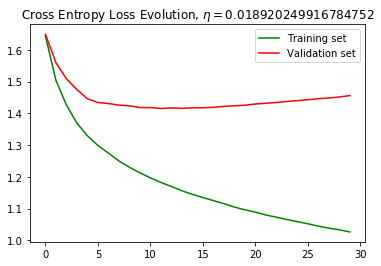

<Figure size 432x288 with 0 Axes>

In [104]:
visualize_costs(training_set_loss,validation_set_loss, display=True, title='Cross Entropy Loss Evolution, $\eta=0.018920249916784752$', save_name='experiment_1')

In [105]:
test_set_accuracy_1 = ComputeAccuracy(X_test, y_test, W1, b1, W2, b2)

The accuracy achieved on the test set was $50.23\%$

In [106]:
test_set_accuracy_1

50.23

Experiment no.2: Eta = 0.01713848118474131, lambda = 0.0001

In [108]:
GD_params = [100, 0.01713848118474131, 30]

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                 Y_training,
                                                                                 X_validation,
                                                                                 Y_validation,
                                                                                 y_validation,
                                                                                 GD_params,
                                                                                 W1, b1, W2, b2,
                                                                                 regularization_term=0.0001)

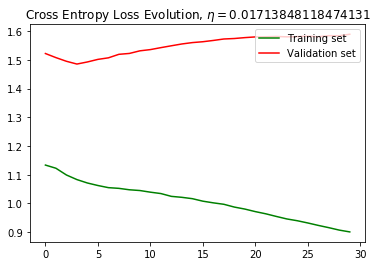

<Figure size 432x288 with 0 Axes>

In [111]:
visualize_costs(training_set_loss,validation_set_loss, display=True, title='Cross Entropy Loss Evolution, $\eta=0.01713848118474131$', save_name='experiment_2')

In [112]:
test_set_accuracy_2 = ComputeAccuracy(X_test, y_test, W1, b1, W2, b2)

The accuracy achieved on the test set was $49.14\%$

In [113]:
test_set_accuracy_2

49.14

Experiment no.3: Eta = 0.02878809988519304, lambda = 0.0001


In [114]:
W1, b1, W2, b2 = initialize_weights()

GD_params = [100, 0.02878809988519304, 30]

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                 Y_training,
                                                                                 X_validation,
                                                                                 Y_validation,
                                                                                 y_validation,
                                                                                 GD_params,
                                                                                 W1, b1, W2, b2,
                                                                                 regularization_term=0.001)

100%|██████████| 30/30 [39:19<00:00, 78.65s/it]


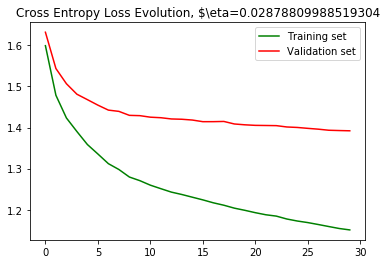

<Figure size 432x288 with 0 Axes>

In [115]:
visualize_costs(training_set_loss,validation_set_loss, display=True, title='Cross Entropy Loss Evolution, $\eta=0.02878809988519304', save_name='experiment_3')

In [116]:
test_set_accuracy_3 = ComputeAccuracy(X_test, y_test, W1, b1, W2, b2)

The accuracy achieved on the test set was $51.04\%$

In [117]:
test_set_accuracy_3

51.04

## Bonus point part

### Exercise 1: Optimize the performance of the network

#### Improvement 1: Keep track of the best model based on validation set performance along with training for more steps

In [1]:
def improvement_1(eta, regularization_term):
    """
     Use all the available data from training, train for more update steps and use your validation set to make 
    sure you don’t overfit or keep a record of the best model before you begin to overfit

    :return: Learnt weight matrices, training and validation set loss evolution 
    """

    W1, b1, W2, b2 = initialize_weights()

    GD_params = [100, eta, 50]

    W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1, b1, W2, b2,
                                                                                     regularization_term)

    return W1, b1, W2, b2, training_set_loss, validation_set_loss

In [125]:
W1_improvement_1, b1_improvement_1, W2_improvement_1, b2_improvement_1, training_set_loss_improvement_1, validation_set_loss_improvement_1 = improvement_1(eta=0.02878809988519304, regularization_term=0.001)


100%|██████████| 40/40 [52:48<00:00, 79.21s/it]


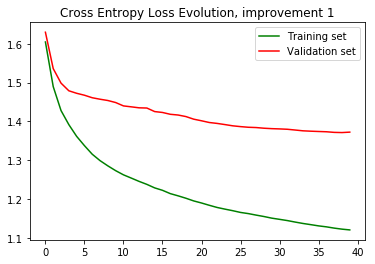

<Figure size 432x288 with 0 Axes>

In [126]:
visualize_costs(training_set_loss_improvement_1, validation_set_loss_improvement_1, display=True,
                title='Cross Entropy Loss Evolution, improvement 1', save_name='improvement_1')

In [29]:
accuracy_improvement_1 = ComputeAccuracy(X_test, y_test, W1_improvement_1, b1_improvement_1, W2_improvement_1, b2_improvement_1)

NameError: name 'W1_improvement_1' is not defined

The accuracy of the first improvement for $\eta=0.02878809988519304$ and $\lambda=0.001$ is $51.53\%$

In [128]:
accuracy_improvement_1

51.53

We will also try the first setting with this improvement so that we can define a pair for $(\eta, \lambda)$ that has the best test set accuracy performance and use it for other improvements

In [27]:
W1_improvement_1_2, b1_improvement_1_2, W2_improvement_1_2, b2_improvement_1_2, training_set_loss_improvement_1_2, validation_set_loss_improvement_1_2 = improvement_1(eta=0.018920249916784752, regularization_term=0.0001)

100%|██████████| 50/50 [1:04:20<00:00, 77.21s/it]


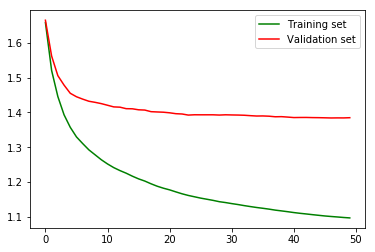

<Figure size 432x288 with 0 Axes>

In [33]:
visualize_costs(training_set_loss_improvement_1_2, validation_set_loss_improvement_1_2, display=True, save_name='Improvement_1_2')

In [ ]:
accuracy_improvement_1_2 = ComputeAccuracy(X_test, y_test, W1_improvement_1_2, b1_improvement_1_2, W2_improvement_1_2, b2_improvement_1_2)

The accuracy of this setting for the first improvement is $51.94\%$

In [31]:
accuracy_improvement_1_2

51.94

Try no.3: Same settings, smaller amount of regularization

In [53]:
W1_improvement_1_3, b1_improvement_1_3, W2_improvement_1_3, b2_improvement_1_3, training_set_loss_improvement_1_3, validation_set_loss_improvement_1_3 = improvement_1(eta=0.018920249916784752, regularization_term=0.0001)

100%|██████████| 50/50 [1:02:45<00:00, 75.30s/it]


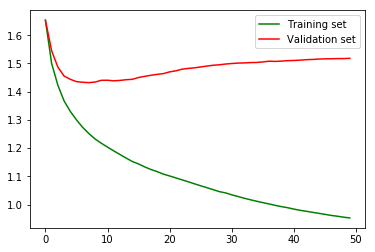

<Figure size 432x288 with 0 Axes>

In [58]:
visualize_costs(training_set_loss_improvement_1_3, validation_set_loss_improvement_1_3, display=True, save_name='Improvement_1_3')

In [59]:
accuracy_improvement_1_3 = ComputeAccuracy(X_test, y_test, W1_improvement_1_3, b1_improvement_1_3, W2_improvement_1_3, b2_improvement_1_3)

The accuracy performance of this setting is 49.94%

In [60]:
accuracy_improvement_1_3

49.94

#### Improvement 2: Switch to He initialization and see the effect it has on training. 

In [44]:
def improvement_2(eta=0.018920249916784752, regularization_term=0.001):
    """
    Switch to He-initialization
    """
    W1_he, b1_he, W2_he, b2_he = he_initialization()

    GD_params = [100, eta, 40]

    W1_he, b1_he, W2_he, b2_he, training_set_loss_he, validation_set_loss_he = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1_he, b1_he, W2_he, b2_he,
                                                                                     regularization_term)

    return W1_he, b1_he, W2_he, b2_he, training_set_loss_he, validation_set_loss_he

In [45]:
W1_improvement_2, b1_improvement_2, W2_improvement_2, b2_improvement_2, \
training_set_loss_improvement_2, validation_set_loss_improvement_2 = improvement_2()

100%|██████████| 40/40 [51:06<00:00, 76.67s/it]


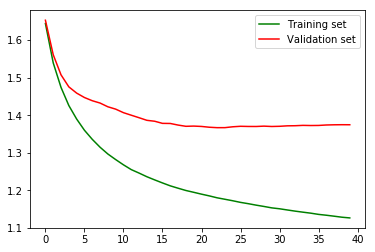

<Figure size 432x288 with 0 Axes>

In [48]:
visualize_costs(training_set_loss_improvement_2, validation_set_loss_improvement_2, display=True, save_name='Improvement_1_2')

In [49]:
accuracy_improvement_2 = ComputeAccuracy(X_test, y_test, W1_improvement_2, b1_improvement_2, W2_improvement_2, b2_improvement_2)

The accuracy of this setting is 51.44%

In [50]:
accuracy_improvement_2

51.44

#### Improvement 3: You could also explore whether having more hidden nodes improves the final classification rate. One would expect that with more hidden nodes then the amount of regularization would have to increase.

In [63]:
def improvement_3(eta=0.018920249916784752, regularization_term=0.001):
    """
     You could also explore whether having more hidden nodes improves the final classification rate. 
    One would expect that with more hidden nodes then the amount of regularization would have to increase.
    """

    W1_100, b1_100, W2_100, b2_100 = initialize_weights(m=100)

    GD_params = [100, eta, 30]

    W1_100, b1_100, W2_100, b2_100, training_set_loss_100, validation_set_loss_100 = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1_100, b1_100, W2_100, b2_100,
                                                                                     regularization_term)

    return W1_100, b1_100, W2_100, b2_100, training_set_loss_100, validation_set_loss_100

In [64]:
W1_improvement_3, b1_improvement_3, W3_improvement_3, b3_improvement_3, \
training_set_loss_improvement_3, validation_set_loss_improvement_3 = improvement_3()

100%|██████████| 30/30 [37:43<00:00, 75.45s/it]


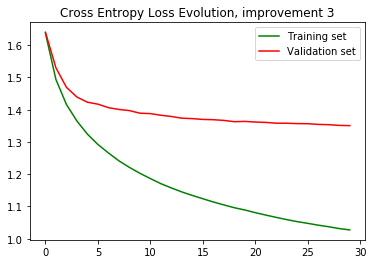

<Figure size 432x288 with 0 Axes>

In [65]:
visualize_costs(training_set_loss_improvement_3, validation_set_loss_improvement_3, display=True,
                title='Cross Entropy Loss Evolution, improvement 3', save_name='improvement_3')

In [66]:
accuracy_improvement_3 = ComputeAccuracy(X_test, y_test, W1_improvement_3, b1_improvement_3, W3_improvement_3, b3_improvement_3)

The accuracy achieved is %

In [67]:
accuracy_improvement_3

53.48

#### Improvement 4: Play around with different approaches to anneal the learning rate. For example you can keep the learning rate fixed over several epochs then decay it by a factor of 10 after n epochs.

In [68]:
    def improvement_4(eta=0.018920249916784752, regularization_term=0.001):
        """
        ﻿Play around with different approaches to anneal the learning rate.
        For example you can keep the learning rate fixed over several epochs then decay it by a factor of 10 after n epochs.
        """
        
        W1_annealing, b1_annealing, W2_annealing, b2_annealing = initialize_weights()
        
        GD_params = [100, eta, 30]

        W1_annealing, b1_annealing, W2_annealing, b2_annealing, training_set_loss_annealing, validation_set_loss_annealing = \
            MiniBatchGDwithMomentum( X_training,
                                     Y_training,
                                     X_validation,
                                     Y_validation,
                                     y_validation,
                                     GD_params,
                                     W1_annealing, b1_annealing, W2_annealing, b2_annealing,
                                     regularization_term,
                                     with_annealing=True)

        return W1_annealing, b1_annealing, W2_annealing, b2_annealing, training_set_loss_annealing, validation_set_loss_annealing

In [69]:
W1_improvement_4, b1_improvement_4, W4_improvement_4, b4_improvement_4, \
training_set_loss_improvement_4, validation_set_loss_improvement_4 = improvement_4()

100%|██████████| 30/30 [36:44<00:00, 73.49s/it]


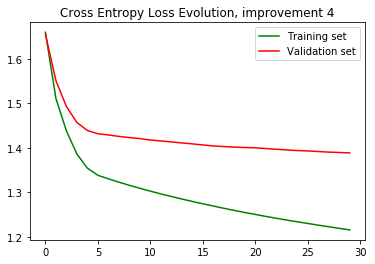

<Figure size 432x288 with 0 Axes>

In [70]:
visualize_costs(training_set_loss_improvement_4, validation_set_loss_improvement_4, display=True,
                title='Cross Entropy Loss Evolution, improvement 4', save_name='improvement_4')

In [71]:
accuracy_improvement_4 = ComputeAccuracy(X_test, y_test, W1_improvement_4, b1_improvement_4, W4_improvement_4, b4_improvement_4)

Test set accuracy performance achieved: %

In [72]:
accuracy_improvement_4

51.34

### Exercise 2: Train network using a different activation to ReLu 

We make use of the leaky ReLu function in order to observe any possible differences in the training process

In [73]:
    def try_1(eta=0.018920249916784752, regularization_term=0.001):
        
        W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1 = initialize_weights()

        GD_params = [100, eta, 30]

        W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1, training_set_loss_leaky_1, validation_set_loss_leaky_1 = \
            MiniBatchGDwithMomentum(X_training,
                                    Y_training,
                                    X_validation,
                                    Y_validation,
                                    y_validation,
                                    GD_params,
                                    W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1,
                                    regularization_term,
                                    with_leaky_relu=True)

        return W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1, training_set_loss_leaky_1, validation_set_loss_leaky_1

In [74]:
W1_try_1, b1_try_1, W2_try_1, b2_try_1, \
training_set_loss_try_1, validation_set_loss_try_1 = try_1()

100%|██████████| 30/30 [37:30<00:00, 75.03s/it]


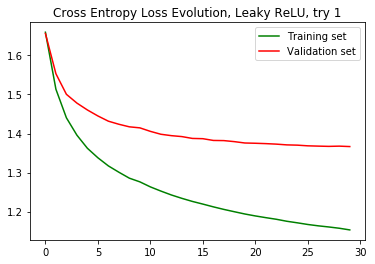

<Figure size 432x288 with 0 Axes>

In [75]:
visualize_costs(training_set_loss_try_1, validation_set_loss_try_1, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 1', save_name='try_1')

In [76]:
accuracy_try_1 = ComputeAccuracy(X_test, y_test, W1_try_1, b1_try_1, W2_try_1, b2_try_1)

In [77]:
accuracy_try_1

51.47